In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

Для начала построим матрицу ковариаций процентных ставок LIBOR, Mosprime и курса доллара (используются данные за 2 года). Данную матрицу будем использовать для построения зависимых винеровских приращений, которые нужны для единовременной симуляции скоррелированных риск факторов. Для этого сразу найдем разложение Холецкого матрицы и реализуем генерацию скоррелированных приращений.

In [2]:
cov_matrix = np.array([[ 9.25394607e-05,  1.23104541e-04, -3.90231986e-02],
                       [ 1.23104541e-04,  2.00912387e-04, -5.44716292e-02],
                       [-3.90231986e-02, -5.44716292e-02,  2.79467296e+01]])

In [3]:
cholesky = np.linalg.cholesky(cov_matrix)

In [4]:
def corr_wiener(a=1):
    return np.dot(cholesky, np.random.randn(3, a))*np.sqrt(dt) / np.sqrt(cholesky.diagonal()).reshape((3, 1))

Уравнения для моделирования риск-факторов:

\begin{equation*}
    \begin{aligned}
        dr_t &= (\theta_t - \alpha r_t)dt + \sigma_t dW_t, \qquad (\text{модель Халла-Уайта})\\
        \frac{dX_t}{X_t} &= (r_f - r_d + \Lambda)dt + \sigma dW_t \qquad (\text{Логарифмическая модель})
    \end{aligned}
\end{equation*}

Зафиксируем правую границу интервала $[0, T]$ на уровне $T = 1$ (нормировка временного интервала) и число разбиений $n$,  а также зададим все необходимые для решения уравнений константы и функции (средний уровень процентной ставки $\theta_t$ определяется с помощью интерполяции заданных в условии значений).

In [5]:
T = 1
n = 500

dt = T/n
t = np.arange(0, T, dt)

alpha_rub = 0.03
alpha_usd = 0.02
sigma_change = 0.1
Lambda = 0.015

sigma_rub = 0.3

sigma_usd = 0.1

def theta_rub(t):
    if t <= 90/730:
        return 0.0851987757
    elif t <= 180/730:
        return 0.08686113191
    elif t <= 270/730:
        return 0.08904603831
    elif t <= 360/730:
        return 0.09049386475
    else:
        return 0.09166205174

def theta_usd(t):
    if t <= 90/730:
        return 0.02842530622
    elif t <= 180/730:
        return 0.0280778295
    elif t <= 270/730:
        return 0.02794769102
    elif t<= 360/730:
        return 0.02786721861
    elif t <= 450/730:
        return 0.02781489328
    elif t <= 540/730:
        return 0.02764748579
    elif t <= 630/730:
        return 0.02743857526
    else:
        return 0.02722993319

Используем разностную схему Эйлера-Маруямы для решения уравнений. Для модели Халла-Уайта она имеет вид:

$$ r(t_i) = r(t_{i-1}) + (\theta(t_{i-1}) - \alpha r(t_{i-1}))\Delta t + \sigma (t_{i-1}) (W(t_i) - W(t_{i-1})), \qquad i=\overline{1, n}$$

Эту модель будем использовать для моделирования долларованых и рублевых процентных ставок.

Для логарифмической модели разностная схема имеет вид:

$$ X(t_i) = X(t_{i-1}) + X(t_{i-1})(r_f - r_d + \Lambda)\Delta t + \sigma X(t_{i-1}) (W(t_i) - W(t_{i-1})), \qquad i=\overline{1, n}$$

Данная модель будет использоватьтся для моделирования обменного курса (рубль/доллар).

Все начальные значения для уравнений возьмем из исторических данных.

In [6]:
R_rub = []
R_usd = []
X = []

r_usd_0 = 0.0209
r_rub_0 = 0.0863
X0 = 67.0795

iterations = 0

# Квантиль
quantile = 0.95

# Точность вычисления квантили
eps = 1e-4

X_quantile_cur = 0
usd_quantile_cur = 0
rub_quantile_cur = 0

while True:
    iterations += 1
    r_usd_current = [r_usd_0]
    r_rub_current = [r_rub_0]
    X_current = [X0]
    for time in t[1:]:
        r_usd_wiener, r_rub_wiener, X_wiener = corr_wiener()
        
        X_next = X_current[-1]*(1 + (r_usd_current[-1] - r_rub_current[-1] + Lambda)*dt + sigma_change*X_wiener[0])
        X_current.append(X_next)
        
        r_usd_next = r_usd_current[-1] + (theta_usd(time) - alpha_usd*r_usd_current[-1])*dt + sigma_usd*r_usd_wiener[0]
        r_usd_current.append(r_usd_next)
        
        r_rub_next = r_rub_current[-1] + (theta_rub(time) - alpha_rub*r_rub_current[-1])*dt + sigma_rub*r_rub_wiener[0]
        r_rub_current.append(r_rub_next)
        
    X.append(X_current)
    R_usd.append(r_usd_current)
    R_rub.append(r_rub_current)
    
    X_array = np.array(X)[:, -1]
    usd_array = np.array(R_usd)[:, -1]
    rub_array = np.array(R_rub)[:, -1]
    
    X_quantile = np.quantile(X_array, quantile)
    usd_quantile = np.quantile(usd_array, quantile)
    rub_quantile = np.quantile(rub_array, quantile)

    if abs(X_quantile - X_quantile_cur)/X_quantile < eps and abs(rub_quantile - rub_quantile_cur)/rub_quantile < eps and abs(usd_quantile - usd_quantile_cur)/usd_quantile < eps:
        print('Финальная итерация №%d' % iterations)
        print('Относительная разность квантилей обменного курса       = %.5f' % (abs(X_quantile - X_quantile_cur)/X_quantile))
        print('Относительная разность квантилей RUB процентной ставки = %.5f' % (abs(rub_quantile - rub_quantile_cur)/rub_quantile))
        print('Относительная разность квантилей USD процентной ставки = %.5f\n' % (abs(usd_quantile-usd_quantile_cur)/usd_quantile))
        break
    else:
        print('Итерация №%d' % iterations)
        print('Относительная разность квантилей обменного курса       = %.5f' % (abs(X_quantile - X_quantile_cur)/X_quantile))
        print('Относительная разность квантилей RUB процентной ставки = %.5f' % (abs(rub_quantile - rub_quantile_cur)/rub_quantile))
        print('Относительная разность квантилей USD процентной ставки = %.5f\n' % (abs(usd_quantile-usd_quantile_cur)/usd_quantile))
        
    X_quantile_cur = X_quantile
    usd_quantile_cur = usd_quantile
    rub_quantile_cur = rub_quantile

Итерация №1
Относительная разность квантилей обменного курса       = 1.00000
Относительная разность квантилей RUB процентной ставки = 1.00000
Относительная разность квантилей USD процентной ставки = 1.00000

Итерация №2
Относительная разность квантилей обменного курса       = 0.02063
Относительная разность квантилей RUB процентной ставки = 0.19294
Относительная разность квантилей USD процентной ставки = 0.21635

Итерация №3
Относительная разность квантилей обменного курса       = 0.12898
Относительная разность квантилей RUB процентной ставки = 0.01026
Относительная разность квантилей USD процентной ставки = 0.01152

Итерация №4
Относительная разность квантилей обменного курса       = 0.00621
Относительная разность квантилей RUB процентной ставки = 0.01037
Относительная разность квантилей USD процентной ставки = 0.00405

Итерация №5
Относительная разность квантилей обменного курса       = 0.00624
Относительная разность квантилей RUB процентной ставки = 0.01047
Относительная разность ква

In [7]:
print('Финальнаяя итерация №%d' % iterations)
print('Относительная разность квантилей обменного курса       = %.5f' % (abs(X_quantile - X_quantile_cur)/X_quantile))
print('Относительная разность квантилей RUB процентной ставки = %.5f' % (abs(rub_quantile - rub_quantile_cur)/rub_quantile))
print('Относительная разность квантилей USD процентной ставки = %.5f\n' % (abs(usd_quantile-usd_quantile_cur)/usd_quantile))

Финальнаяя итерация №811
Относительная разность квантилей обменного курса       = 0.00004
Относительная разность квантилей RUB процентной ставки = 0.00005
Относительная разность квантилей USD процентной ставки = 0.00001



Теперь построим графики для всех риск-факторов, на которых изобразим полученные симуляции. Также построим гистограммы значений в конечный момент времени и отметим на них искомый 95-процентный квантиль.

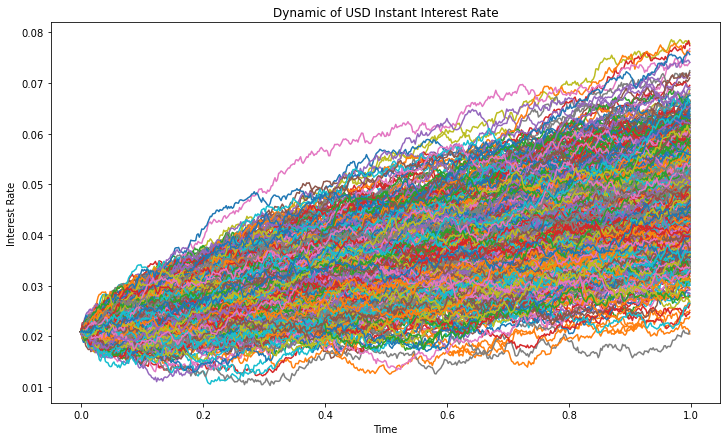

In [8]:
plt.figure(figsize=(12, 7))
for i in range(iterations):
    plt.plot(t, R_usd[i])
plt.title("Dynamic of USD Instant Interest Rate")
plt.ylabel("Interest Rate")
plt.xlabel("Time")
plt.show()

/Users/mihailmihaylov/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


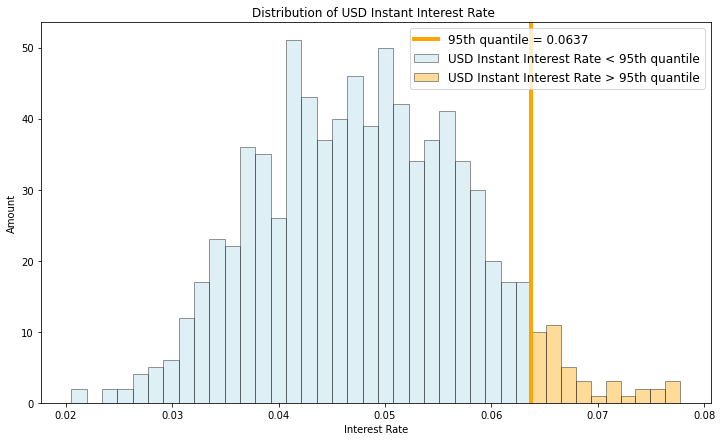

In [9]:
coef = (usd_quantile - np.min(usd_array))/(np.max(usd_array) - usd_quantile)
bins = 30
plt.figure(figsize=(12, 7))

sns.distplot(usd_array[usd_array <= usd_quantile], color = 'lightblue', bins = bins, hist=True,
             kde=False, hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
sns.distplot(usd_array[usd_array > usd_quantile], color = 'orange', bins = int(bins/coef)+1, hist=True,
             kde=False,hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});
plt.axvline(x=usd_quantile, linewidth=4, color = 'orange')
plt.ylabel("Amount")
plt.xlabel("Interest Rate")
plt.title("Distribution of USD Instant Interest Rate ")
plt.legend([f'95th quantile = {round(usd_quantile, 4)}',
            'USD Instant Interest Rate < 95th quantile', 
            'USD Instant Interest Rate > 95th quantile'], fontsize=12);

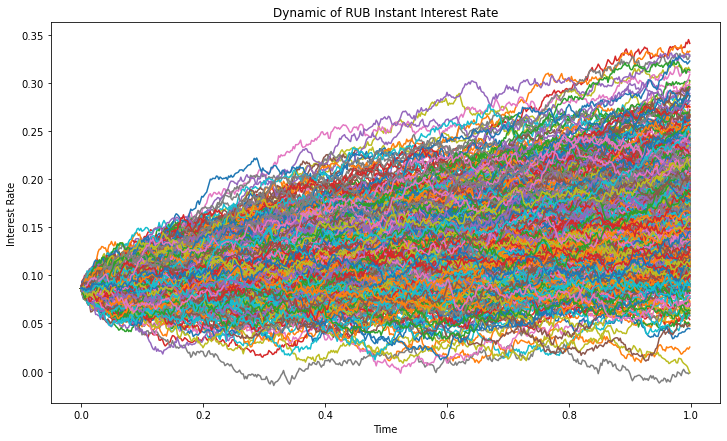

In [10]:
plt.figure(figsize=(12, 7))
for i in range(iterations):
    plt.plot(t, R_rub[i])
plt.title("Dynamic of RUB Instant Interest Rate")
plt.ylabel("Interest Rate")
plt.xlabel("Time")
plt.show()

/Users/mihailmihaylov/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


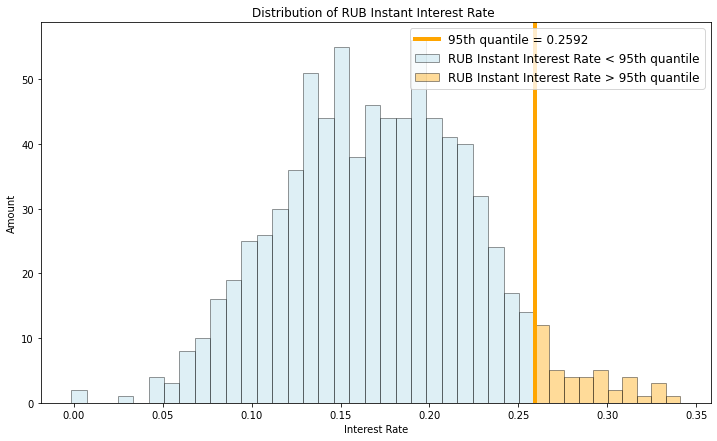

In [11]:
coef = (rub_quantile - np.min(rub_array)) / (np.max(rub_array) - rub_quantile)
bins = 30
plt.figure(figsize=(12, 7))

sns.distplot(rub_array[rub_array <= rub_quantile], color = 'lightblue', bins = bins, hist=True,
             kde=False, hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
sns.distplot(rub_array[rub_array > rub_quantile], color = 'orange', bins = int(bins/coef)+1, hist=True,
             kde=False,hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});
plt.axvline(x=rub_quantile, linewidth=4, color = 'orange')
plt.ylabel("Amount")
plt.xlabel("Interest Rate")
plt.title("Distribution of RUB Instant Interest Rate ")
plt.legend([f'95th quantile = {round(rub_quantile, 4)}',
            'RUB Instant Interest Rate < 95th quantile', 
            'RUB Instant Interest Rate > 95th quantile'], fontsize=12);

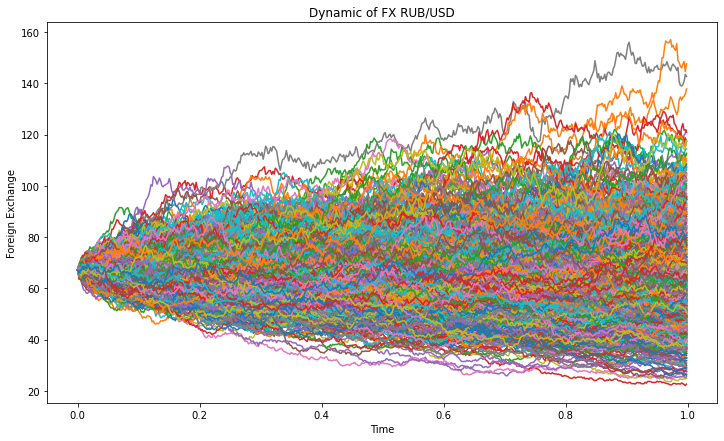

In [12]:
plt.figure(figsize=(12, 7))
for i in range(iterations):
    plt.plot(t, X[i])
plt.title("Dynamic of FX RUB/USD")
plt.ylabel("Foreign Exchange")
plt.xlabel("Time")
plt.show()

/Users/mihailmihaylov/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


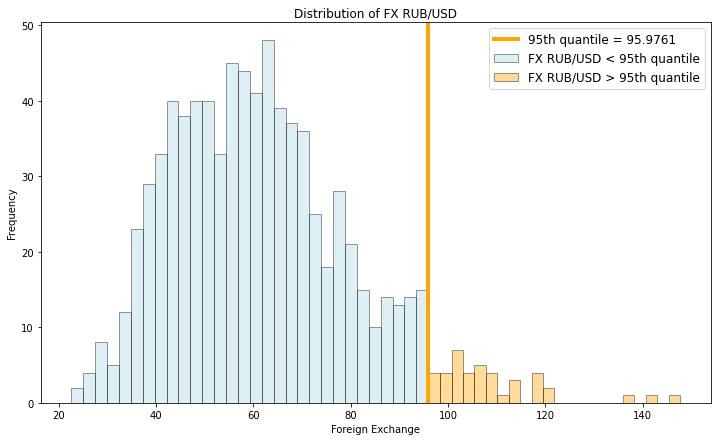

In [13]:
plt.figure(figsize=(12, 7))
coef = (X_quantile - np.min(X_array))/(np.max(X_array) - X_quantile)
bins = 30
sns.distplot(X_array[X_array <= X_quantile], color = 'lightblue', bins = bins, hist=True,
             kde=False, hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
sns.distplot(X_array[X_array > X_quantile], color = 'orange', bins = int(bins/coef)+1, hist=True,
             kde=False,hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});
plt.axvline(x=X_quantile, linewidth=4, color = 'orange')
plt.ylabel("Frequency")
plt.xlabel("Foreign Exchange")
plt.title("Distribution of FX RUB/USD")
plt.legend([f'95th quantile = {round(X_quantile, 4)}',
            'FX RUB/USD < 95th quantile', 
            'FX RUB/USD > 95th quantile'], fontsize=12);

$\textbf{Итог}$

В процессе работы было реализовано построение симуляций скоррелированных риск-факторов (процентная ставка рубля, доллара и обменный курс) с помощью численного решения стохастических дифференциальных уравнений. Также реализовано вычисление квантилей распределения для всех риск-факторов заданного уровня (95%) с заданной точностью ($10^{-4}$).